In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple
from quantization.norm_pq import NormPQ
from quantization.residual_pq import ResidualPQ
from quantization.base_pq import PQ
from quantization.utils import execute


from quantization.constants import (
    PARTITION,
    NUM_CODEBOOKS,
    NUM_CODEWORDS,
)


In [13]:
def generate_data(
    num_atoms: int = 10**3,
    len_signal: int = 10**4,
    num_signals: int = 1,
    num_best_atoms: int =5,
    seed: int = 0,
) -> Tuple[np.ndarray, np.ndarray]:

	
    rng = np.random.default_rng(seed)
    atoms_array = np.empty((num_atoms, len_signal))
    means = rng.normal(size=num_atoms)
    atoms_array = np.empty((num_atoms, len_signal))
    for idx in range(num_atoms):
      atoms_array[idx] = rng.normal(loc=means[idx], size=len_signal)
    signal = rng.normal(loc=rng.normal(), size=(num_signals, len_signal))
    if num_signals == 1:
        signal = signal.reshape(1,-1)

    return atoms_array, signal

In [14]:
def sample_complexity(dimension):

    seed = 3
    num_best_atoms = 10

    atoms, signals = generate_data(num_atoms=1000, len_signal=dimension)

    naive_candidates_array = (
                np.matmul(atoms, signals.transpose())
                .argsort(axis=0)[:num_best_atoms]
                .transpose()
            )

    pqs = [
    PQ(M=PARTITION, Ks=NUM_CODEWORDS) for _ in range(NUM_CODEBOOKS - 1)
    ]
    quantizer = ResidualPQ(pqs=pqs)
    quantizer = NormPQ(n_percentile=NUM_CODEWORDS, quantize=quantizer)
    start_time = time.time()

    candidates_array, budget_array,runtime = execute(
        seed=seed,
        top_k=num_best_atoms,
        pq=quantizer,
        X=atoms,
        Q=signals.astype("float32"),
        G=naive_candidates_array,
        num_codebooks=NUM_CODEBOOKS,
        num_codewords=NUM_CODEWORDS,
        train_size=atoms.shape[0],
    )
    # includes the time finding recall (other baselines don't)
    runtime = time.time() - start_time
    
    return runtime


In [7]:
seed = 0
num_best_atoms = 190
atoms, signals = generate_data(num_atoms=300, len_signal=100000, num_best_atoms=num_best_atoms)

begin = time.time()
naive_candidates_array = np.matmul(atoms, signals.transpose())
naive_candidates_array = naive_candidates_array.argsort(axis=0).transpose()
naive_time = time.time()-begin

pqs = [
    PQ(M=PARTITION, Ks=NUM_CODEWORDS) for _ in range(NUM_CODEBOOKS - 1)
]
quantizer = ResidualPQ(pqs=pqs)
quantizer = NormPQ(n_percentile=NUM_CODEWORDS, quantize=quantizer)

start_time = time.time()
candidates_array, budget_array,runtime = execute(
    seed=seed,
    top_k=num_best_atoms,
    pq=quantizer,
    X=atoms,
    Q=signals.astype("float32"),
    G=naive_candidates_array,
    num_codebooks=NUM_CODEBOOKS,
    num_codewords=NUM_CODEWORDS,
    train_size=atoms.shape[0],
)
# includes the time finding recall (other baselines don't)
# runtime = time.time() - start_time


print(f"speedup={naive_time/runtime}")
intersection = np.intersect1d(candidates_array[0], naive_candidates_array[0,:num_best_atoms])
precision = len(intersection)
print(f"precision={precision}")


/home/dhair/progrms/DaiictSem3/IR/project/toUpload/quantization/base_pq.py:50: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  self.codewords[m, :, :self.Ds[m+1] - self.Ds[m]], _ = kmeans2(vecs_sub, self.Ks, iter=iter, minit='points')


speedup=2.5136810602821718
precision=80


/home/dhair/progrms/DaiictSem3/IR/project/toUpload/quantization/base_pq.py:50: UserWarning: One of the clusters is empty. Re-run kmeans with a different initialization.
  self.codewords[m, :, :self.Ds[m+1] - self.Ds[m]], _ = kmeans2(vecs_sub, self.Ks, iter=iter, minit='points')


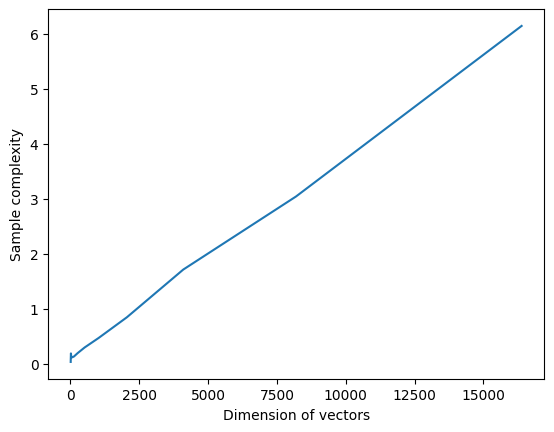

In [10]:
dimensions = [2**i for i in range(3,15)]
sample_comp  = []
for dimension in dimensions:
    sample_comp.append(sample_complexity(dimension))

plt.plot(dimensions,sample_comp)
plt.xlabel("Dimension of vectors")
plt.ylabel("Sample complexity")

plt.show()

MovieLens Data

In [ ]:
import numpy as np
from sklearn.decomposition import TruncatedSVD
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

# Load the MovieLens dataset (100k version for simplicity)
reader = Reader(line_format='user item rating timestamp', sep='\t')
data = Dataset.load_builtin('ml-1m')
trainset, testset = train_test_split(data, test_size=0.2)

# Build a user-item matrix
user_item_matrix = np.zeros((trainset.n_users, trainset.n_items))
for uid, iid, rating in trainset.all_ratings():
    user_item_matrix[int(uid), int(iid)] = rating

# Use SVD to reduce dimensionality
svd = TruncatedSVD(n_components=50)
atoms = svd.fit_transform(user_item_matrix.T)  # Transpose to get item embeddings

# Create a signal (simulate a user's preference vector)
user_id = 0  # Choose a user ID from the dataset
user_ratings = user_item_matrix[user_id]
signal = np.dot(user_ratings, atoms)  # Weighted average of rated item embeddings
signals = signal[np.newaxis, :]  # Ensure signal has 2D shape for batch processing

# Initialize Greedy MIPS parameters
budget = 10  # Number of candidates to screen
num_best_atoms = 10  # Top-k items to retrieve

# Run neq MIPS
pqs = [
    PQ(M=PARTITION, Ks=NUM_CODEWORDS) for _ in range(NUM_CODEBOOKS - 1)
]
quantizer = ResidualPQ(pqs=pqs)
quantizer = NormPQ(n_percentile=NUM_CODEWORDS, quantize=quantizer)

start_time = time.time()
candidates, sample_complexity,runtime = execute(
    seed=seed,
    top_k=num_best_atoms,
    pq=quantizer,
    X=atoms,
    Q=signals.astype("float32"),
    G=naive_candidates_array,
    num_codebooks=NUM_CODEBOOKS,
    num_codewords=NUM_CODEWORDS,
    train_size=atoms.shape[0],
)

# Output results
print(f"Top {num_best_atoms} candidates (indices):\n{candidates[0]}")
print(f"Total complexity: {sample_complexity[0]}")

# Naive approach for validation
inner_products = np.dot(atoms, signal)
top_k_naive = np.argsort(inner_products)[-num_best_atoms:][::-1]
print(f"Top {num_best_atoms} candidates using naive approach (indices): {top_k_naive}")

# Compare results
accuracy = len(np.intersect1d(candidates[0], top_k_naive)) / num_best_atoms
print(f"Accuracy compared to naive method: {accuracy * 100:.2f}%")

# Compute speedup ratio
total_naive_computations = atoms.shape[0] * atoms.shape[1]
average_complexity = sample_complexity.mean()
speedup_ratio = total_naive_computations / average_complexity
print(f"Speedup ratio: {speedup_ratio:.2f} times faster than naive computation.")

Top 10 candidates (indices):
[ 31.  95. 353. 455. 118. 268. 514. 152. 338. 187.]
Total complexity: 19423.025850929942
Top 10 candidates using naive approach (indices): [ 31  95 187 514 152 353 268 338 511 165]
Accuracy compared to naive method: 80.00%
Speedup ratio: 9.47 times faster than naive computation.
